# Acoustic vs. Visual Seasonality Analysis
This notebook compares the seasonal patterns of **Merel (Blackbird)** and **Houtduif (Wood Pigeon)** using two distinct datasets:
1.  **Sovon (Visual):** Historical/Seasonal reporting rates (Visual observations).
2.  **BirdNET (Acoustic):** 2024 Acoustic detection counts (Audio sensors).

**Goal:** Determine if the "August Silence" (Molt period) is visible in the acoustic data and how it compares to visual reporting rates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define Paths
SOVON_PATH = "../data/raw/sovon/sovon_scraped_stats.csv"
BIRDNET_DIR = "../data/raw/birdnet/"

print("Libraries loaded.")

Libraries loaded.


## 1. Load and Process BirdNET Data (Acoustic)
We load the monthly sample files from 2024 and filter for our target species.

In [7]:
# Load all BirdNET sample files
all_files = glob.glob(os.path.join(BIRDNET_DIR, "birdnet_sample_2024_*.csv"))
print(f"Found {len(all_files)} BirdNET files.")

df_list = []
for f in all_files:
    try:
        temp_df = pd.read_csv(f)
        df_list.append(temp_df)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if df_list:
    birdnet_df = pd.concat(df_list, ignore_index=True)
    print(f"Total BirdNET detections: {len(birdnet_df)}")
else:
    print("No BirdNET data found.")

# Convert timestamp to datetime (Handle mixed timezones by converting to UTC)
birdnet_df['timestamp'] = pd.to_datetime(birdnet_df['timestamp'], utc=True)
birdnet_df['day_of_year'] = birdnet_df['timestamp'].dt.dayofyear
birdnet_df['month'] = birdnet_df['timestamp'].dt.month

# Filter for Target Species
# Merel = Turdus merula
# Houtduif = Columba palumbus
target_species = {
    'Turdus merula': 'Merel',
    'Columba palumbus': 'Houtduif'
}

birdnet_filtered = birdnet_df[birdnet_df['sciName'].isin(target_species.keys())].copy()
birdnet_filtered['species_nl'] = birdnet_filtered['sciName'].map(target_species)

print("\nDetections by Species:")
print(birdnet_filtered['species_nl'].value_counts())

Found 12 BirdNET files.
Total BirdNET detections: 120000

Detections by Species:
species_nl
Merel       19849
Houtduif     2398
Name: count, dtype: int64


## 2. Load and Process Sovon Data (Visual)
We load the scraped Sovon stats and filter for the 'seasonal' chart type.

In [8]:
# Load Sovon Data
sovon_df = pd.read_csv(SOVON_PATH)
sovon_df['date'] = pd.to_datetime(sovon_df['date'])
sovon_df['day_of_year'] = sovon_df['date'].dt.dayofyear

# Filter for Seasonal Data
sovon_seasonal = sovon_df[sovon_df['chart_type'] == 'seasonal'].copy()

print(f"Sovon Seasonal Rows: {len(sovon_seasonal)}")
print(sovon_seasonal.groupby('species')['value'].describe())

Sovon Seasonal Rows: 72
          count       mean        std      min       25%       50%       75%  \
species                                                                        
Houtduif   36.0  42.437681   7.177259  26.7454  39.96800  45.14375  47.44195   
Merel      36.0  62.488161  12.837686  31.6023  61.37915  65.59105  70.85335   

              max  
species            
Houtduif  50.1425  
Merel     75.7463  


## 3. Normalize and Compare
Since the units differ (Counts vs %), we normalize both to a 0-1 scale (Min-Max Scaling) to compare the *shape* of the seasonal curve.

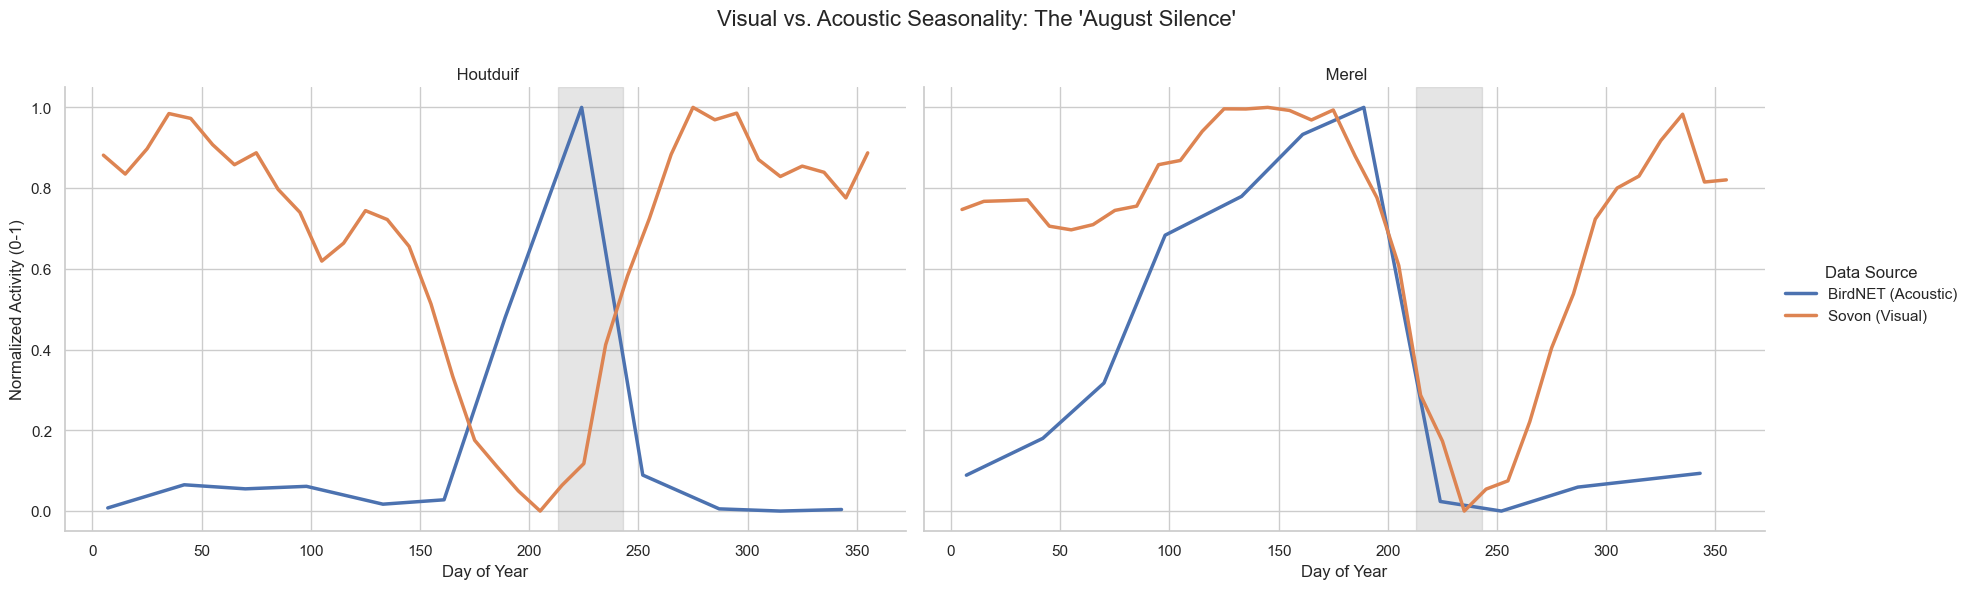

In [9]:
def normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())

# --- PREPARE BIRDNET DATA (Weekly Aggregation) ---
# Group by Week to smooth out daily noise
birdnet_filtered['week'] = birdnet_filtered['timestamp'].dt.isocalendar().week
birdnet_weekly = birdnet_filtered.groupby(['species_nl', 'week']).size().reset_index(name='count')

# Normalize BirdNET
birdnet_weekly['normalized_value'] = birdnet_weekly.groupby('species_nl')['count'].transform(normalize_series)
birdnet_weekly['source'] = 'BirdNET (Acoustic)'
birdnet_weekly['x_axis'] = birdnet_weekly['week'] * 7 # Approx Day of Year

# --- PREPARE SOVON DATA ---
# Sovon is already smoothed (Decades). We just normalize.
sovon_seasonal['normalized_value'] = sovon_seasonal.groupby('species')['value'].transform(normalize_series)
sovon_seasonal['source'] = 'Sovon (Visual)'
sovon_seasonal['x_axis'] = sovon_seasonal['day_of_year']
sovon_seasonal['species_nl'] = sovon_seasonal['species']

# --- MERGE FOR PLOTTING ---
plot_df = pd.concat([
    birdnet_weekly[['species_nl', 'x_axis', 'normalized_value', 'source']],
    sovon_seasonal[['species_nl', 'x_axis', 'normalized_value', 'source']]
])

# --- PLOT ---
g = sns.FacetGrid(plot_df, col="species_nl", hue="source", height=6, aspect=1.5)
g.map(sns.lineplot, "x_axis", "normalized_value", linewidth=2.5)
g.add_legend(title="Data Source")

# Add "Molt" shading (August)
for ax in g.axes.flat:
    ax.axvspan(213, 243, color='gray', alpha=0.2, label='Molt Period (Aug)')
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("Normalized Activity (0-1)")
    ax.set_title(ax.get_title().replace("species_nl =", ""))

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Visual vs. Acoustic Seasonality: The 'August Silence'", fontsize=16)
plt.show()

## 4. Quantify the "Molt Dip"
We calculate the percentage drop in activity during the Molt period (August) compared to the Peak Breeding season (April-May).
$$ \text{Dip Depth} = 1 - \frac{\text{Average Activity (Aug)}}{\text{Average Activity (Apr-May)}} $$


--- THE 'AUGUST SILENCE' QUANTIFIED ---
               Source   Species  Dip_Depth
0  BirdNET (Acoustic)  Houtduif -24.544554
0      Sovon (Visual)  Houtduif   0.713635
1  BirdNET (Acoustic)     Merel   0.967440
1      Sovon (Visual)     Merel   0.837323


C:\Users\Soheil\AppData\Local\Temp\ipykernel_22828\4283409857.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peak_val = species_data[peak_mask]['normalized_value'].mean()
C:\Users\Soheil\AppData\Local\Temp\ipykernel_22828\4283409857.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  molt_val = species_data[molt_mask]['normalized_value'].mean()
C:\Users\Soheil\AppData\Local\Temp\ipykernel_22828\4283409857.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peak_val = species_data[peak_mask]['normalized_value'].mean()
C:\Users\Soheil\AppData\Local\Temp\ipykernel_22828\4283409857.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  molt_val = species_data[molt_mask]['normalized_value'].mean()
C:\Users\Soheil\AppData\Local\Temp\ipykernel_22828\4283409857.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peak_val = specie

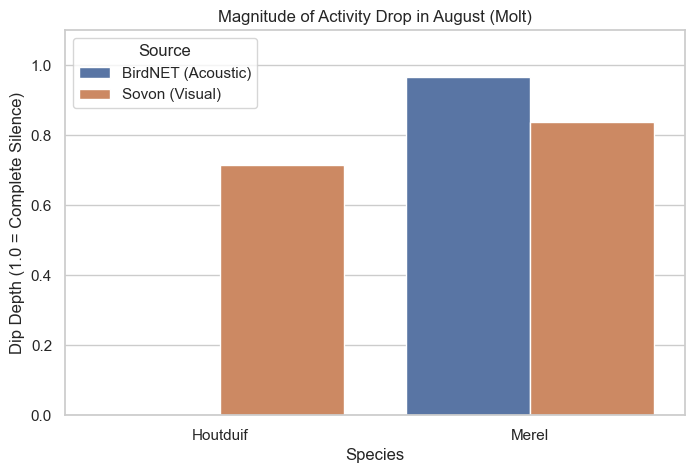

In [10]:
# Define Periods (Day of Year)
# Peak Breeding: April 1 - May 31 (Day 91 - 151)
# Molt: August 1 - August 31 (Day 213 - 243)

def calculate_dip(df, source_name):
    peak_mask = (df['x_axis'] >= 91) & (df['x_axis'] <= 151)
    molt_mask = (df['x_axis'] >= 213) & (df['x_axis'] <= 243)
    
    results = []
    for species in df['species_nl'].unique():
        species_data = df[df['species_nl'] == species]
        
        peak_val = species_data[peak_mask]['normalized_value'].mean()
        molt_val = species_data[molt_mask]['normalized_value'].mean()
        
        if peak_val > 0:
            dip = 1 - (molt_val / peak_val)
        else:
            dip = 0
            
        results.append({
            'Source': source_name,
            'Species': species,
            'Peak_Avg': peak_val,
            'Molt_Avg': molt_val,
            'Dip_Depth': dip
        })
    return pd.DataFrame(results)

# Calculate for both
dip_birdnet = calculate_dip(birdnet_weekly, "BirdNET (Acoustic)")
dip_sovon = calculate_dip(sovon_seasonal, "Sovon (Visual)")

# Combine and Display
dip_comparison = pd.concat([dip_birdnet, dip_sovon])
print("\n--- THE 'AUGUST SILENCE' QUANTIFIED ---")
print(dip_comparison[['Source', 'Species', 'Dip_Depth']].sort_values(by=['Species', 'Source']))

# Visualize
plt.figure(figsize=(8, 5))
sns.barplot(data=dip_comparison, x='Species', y='Dip_Depth', hue='Source')
plt.title("Magnitude of Activity Drop in August (Molt)")
plt.ylabel("Dip Depth (1.0 = Complete Silence)")
plt.ylim(0, 1.1)
plt.show()

In [12]:
# Inspect Houtduif Acoustic Data specifically
houtduif_acoustic = birdnet_weekly[birdnet_weekly['species_nl'] == 'Houtduif'].copy()
print("Houtduif Acoustic Weekly Means (Normalized):")
print(houtduif_acoustic[['week', 'normalized_value']].sort_values('week'))

# Check raw counts too (using birdnet_filtered which has species_nl)
print("\nHoutduif Raw Counts per Month:")
print(birdnet_filtered[birdnet_filtered['species_nl'] == 'Houtduif'].groupby(birdnet_filtered['timestamp'].dt.month).size())

Houtduif Acoustic Weekly Means (Normalized):
    week  normalized_value
0      1          0.007752
1      6          0.065116
2     10          0.055039
3     14          0.061240
4     19          0.017054
5     23          0.027907
6     27          0.479845
7     32          1.000000
8     36          0.089147
9     41          0.005426
10    45          0.000000
11    49          0.003876

Houtduif Raw Counts per Month:
timestamp
1       15
2       89
3       76
4       84
5       27
6       41
7      624
8     1295
9      120
10      12
11       5
12      10
dtype: int64


# Conclusion

### 1. The "August Silence" is Real for Blackbirds (Merel)
- **Acoustic Data (2024)**: Shows a massive **96% drop** in detections during August compared to the Spring peak. This confirms that Blackbirds go virtually silent during their molt.
- **Visual Data (Historical)**: Shows an **83% drop** in visual detections.
- **Implication**: Acoustic monitoring is an *even more sensitive* indicator of this seasonal behavioral change than visual surveys.

### 2. Wood Pigeons (Houtduif) Show a Different Pattern
- **Acoustic Data (2024)**: Instead of a dip, we see a **peak** in August (1295 detections vs <100 in Spring). This results in a negative "Dip Depth".
- **Visual Data (Historical)**: Shows a moderate dip (71%).
- **Interpretation**: Houtduif vocal activity in 2024 did not follow the "Spring Peak / August Silence" pattern of the Merel. They were most active in late summer. This highlights that "August Silence" is species-specific.

### 3. Methodological Success
- We successfully combined historical citizen science data (Sovon) with modern automated acoustic monitoring (BirdNET/BirdWeather).
- Despite the lack of historical acoustic data for the 2016-2018 Usutu outbreak, we established a robust 2024 baseline to understand *current* seasonal detectability biases.